In [ ]:
!wget -O bikeway_fr.geojson https://www.dropbox.com/s/jdedg2wb0al8qt1/bikeway_fr.geojson?dl=1
!wget -O communes_importantes.geojson https://www.dropbox.com/s/6ln3ifs7sh2g2eh/communes_importantes.geojson?dl=1
!wget -O communes_with_all_data.geojson https://www.dropbox.com/s/458sy1xvhy565v5/communes_with_all_data.geojson?dl=1
!wget -O motifs_with_geom.json https://www.dropbox.com/s/fpw8ggkdalc4z20/motifs_with_geom.json?dl=1
!wget -O railroad_fr.geojson https://www.dropbox.com/s/vm0fi19tlinn48x/railroad_fr.geojson?dl=1
!wget -O trainstations.geojson https://www.dropbox.com/s/grshnerusqs2g2z/trainstations.geojson?dl=1


--2022-06-21 08:18:51--  https://www.dropbox.com/s/jdedg2wb0al8qt1/bikeway_fr.geojson?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/jdedg2wb0al8qt1/bikeway_fr.geojson [following]
--2022-06-21 08:18:52--  https://www.dropbox.com/s/dl/jdedg2wb0al8qt1/bikeway_fr.geojson
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc33c68f0dbf88b35822c151db56.dl.dropboxusercontent.com/cd/0/get/Bnldgamcp_IEKsFeom859LwEiXS1GgnlRQzZ4nUOTlvktjoTXs05L4RQ18WZyTTZwB4kLZWYVqFcn9cGeDhOlhvWD81wFDkVj8kFvAlpHV3Pq13TKi6GXKhR51TWQh_AAQoqTs1ybzO_IeA5zSG4m5reZOK-laaJTyXjT4lE9aEr4kkOuwaeUBSuzx3nOkam-hs/file?dl=1# [following]
--2022-06-21 08:18:52--  https://uc33c68f0dbf88b35822c151db56.dl.dropboxusercontent.com/cd/0/get/Bnldgamcp_IEKsFeom859LwEiXS

In [ ]:
!apt install python3-dev
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgdal-dev
!apt-get install libgeos-dev
!pip install cython
!pip install  geopandas  matplotlib-scalebar
!pip install mapclassify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional

In [ ]:
import pandas as pd
import geopandas as gpd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import geopandas as gpd

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
import matplotlib
import os.path as osp

In [ ]:
basedir = "./"
choropleth_column = "all_NIV_EQUIP_2017" # Colonne utilisée pour faire la choropleth

In [ ]:
# On charge les données sur les communes de France
gdf_commune = gpd.read_file(osp.join(basedir,"communes_with_all_data.geojson"))
gdf_commune["dep_code"] = gdf_commune.insee.apply(lambda x : x[:2] if not x.startswith("97") else x[:3])
gdf_commune[choropleth_column] = pd.to_numeric(gdf_commune[choropleth_column],errors="coerce").fillna(0)

# On charge les données sur les contributions extraites
gdf_motifs = gpd.read_file(osp.join(basedir,"motifs_with_geom.json"))
gdf_motifs["dep_code"] = gdf_motifs.code_postal.apply(lambda x : str(x)[:2] if not str(x).startswith("97") else str(x)[:3])
gdf_motifs= gdf_motifs[~gdf_motifs.geometry.isna()].fillna("")

# On charge les données que l'on utilise dans nos deux cartes, l'une sur le réseau férré et la deuxième sur les pistes cyclables
train_rail_gdf = gpd.read_file(osp.join(basedir,"railroad_fr.geojson"))
train_station_gdf = gpd.read_file(osp.join(basedir,"trainstations.geojson"))
bikeways_gdf = gpd.read_file(osp.join(basedir,"bikeway_fr.geojson"))

# Mot utilisé pour filtrer les contributions
selected_verb = ['augmenter','construire','créer','développer','hausser','favoriser',"mettre","changer","améliorer"]
train_key = ['Transport ferroviaire','gare','ligne de train','petite ligne','ter','tgv','train','voie de chemin de fer']
velo_key = ['voie cyclable','vélo','vélo électrique','parking à vélos']

# Filtrage des contributions à l'aides des mots définis dans les listes "selected_verb","train_key", "velo_key"
motifs_vélo = gdf_motifs[(gdf_motifs.verbe.isin(selected_verb)) & (gdf_motifs.keywords_in_onto.apply(lambda x:True if len(set(x.split("|")).intersection(velo_key))>0 else False))]
motifs_train = gdf_motifs[(gdf_motifs.verbe.isin(selected_verb)) & (gdf_motifs.keywords_in_onto.apply(lambda x:True if len(set(x.split("|")).intersection(train_key))>0 else False))]

In [ ]:
class FrancePlot():
    """
    Classe utilisée pour générer une carte 
    """
    def __init__(self,geodataframe_france_data, departement_code_column = "dep_code"):
        self.gdf = geodataframe_france_data
        if geodataframe_france_data.crs.to_epsg() != 2154:
            self.gdf = geodataframe_france_data.to_crs(epsg=2154)
        
       
            
        self.dep_column = departement_code_column
        self.dom_tom=['971','972','973','974','976']
        self.pos_plot={
            "971":(0, 0),
            "972":(1, 0),
            "973":(2, 0),
            "974":(3, 0),
            "976":(4, 0),
            "MET":(0, 1)

        }
        self.grid_layout_dimension = (5,5)
        self.bounds = {'971': ((627178.8413446797, 713621.4605659081),
          (1750863.1298003178, 1826468.4241451393)),
         '972': ((690569.7007008877, 736117.5627935883),
          (1591779.556564982, 1645737.000637843)),
         '973': ((99165.93669401045, 429570.11052098696),
          (233811.5998056135, 636456.9044657239)),
         '974': ((314661.2167918241, 379240.5283951769),
          (7634114.280274536, 7691273.679510377)),
         '976': ((501990.5033624891, 532559.5059372503),
          (8560529.662855903, 8603051.702732448)),
         'MET': ((99040.00733144674, 1242446.4545588917),
          (6046527.880333824, 7110478.98836301))}
        
        self.coordinates_system = {
            "971":5490,
            "972":5490,
            "973":2972,
            "974":2975,
            "976":4471,
            "MET":2154
        }
        
        self.fig = None
        self.axes = {}
        
    
    def init_plot(self,column,figsize=(20,20),**plot_args):
        """
        Génére une choropleth avec la variable indiqué dans "column"
        """
        if column and not column in self.gdf:
            raise KeyError("%s column was not found in the dataframe" % column)
        vmin = self.gdf[column].min()
        vmax = self.gdf[column].max() # Since we only plot the subset containing each dom tom, we need to manually indicate the min and max value to plot the correct color
        self.fig = plt.figure(figsize=figsize)
        for k in self.pos_plot:
            if k != "MET":
                ax = plt.subplot2grid(self.grid_layout_dimension, self.pos_plot[k])
                if "legend" in plot_args:
                    saved = plot_args["legend"]
                    plot_args["legend"] = False
                self.gdf[self.gdf[self.dep_column] == k].to_crs(epsg=self.coordinates_system[k]).plot(column=column,vmin=vmin,vmax=vmax, ax= ax,**plot_args)

                if "legend" in plot_args:
                    plot_args["legend"] = saved
                self.axes[k] = ax
            else:
                ax = plt.subplot2grid(self.grid_layout_dimension, self.pos_plot[k],rowspan=5,colspan=4)
                self.gdf[~self.gdf[self.dep_column].isin(self.dom_tom)].plot(column=column,ax = ax,**plot_args)
                
                self.axes["MET"] = ax
                
            ax.set_xlim(self.bounds[k][0])
            ax.set_ylim(self.bounds[k][1])
            ax.set_axis_off()
            
    
    def add_trace(self,gdf,column,dep_column,**plot_args):
        """
        Méthode permettant d'ajouter un élément sur la carte.
        """
        if not column in gdf:
            raise KeyError("%s column was not found in the dataframe" % column)
        vmin = gdf[column].min()
        vmax = gdf[column].max()
        if gdf.crs.to_epsg() != 2154:
            gdf = gdf.to_crs(epsg=2154)
           
        for k in self.pos_plot:
            if k != "MET":
                if "legend" in plot_args:
                    saved = plot_args["legend"]
                    plot_args["legend"] = False
                gdf[gdf[dep_column] == k].to_crs(epsg=self.coordinates_system[k]).plot(column=column,vmin=vmin,vmax=vmax, ax= self.axes[k],**plot_args)

                if "legend" in plot_args:
                    plot_args["legend"] = saved
            else:
                gdf[~gdf[self.dep_column].isin(self.dom_tom)].plot(column=column,ax = self.axes["MET"],**plot_args)
        return True
                
    def add_trace_wo_column(self,gdf,dep_column,color="red",**plot_args):
        """
        Méthode permettant d'ajouter un élément sur la carte mais sans indiqué de colonne
        """
        if not dep_column in gdf:
            raise KeyError("%s column was not found in the dataframe" % column)
        if gdf.crs.to_epsg() != 2154:
            gdf = gdf.to_crs(epsg=2154)
           
        for k in self.pos_plot:
            if k != "MET":
                if "legend" in plot_args:
                    saved = plot_args["legend"]
                    plot_args["legend"] = False
                gdf[gdf[dep_column] == k].to_crs(epsg=self.coordinates_system[k]).plot(c=color, ax= self.axes[k],**plot_args)

                if "legend" in plot_args:
                    plot_args["legend"] = saved
            else:
                gdf[~gdf[self.dep_column].isin(self.dom_tom)].plot(c=color,ax = self.axes["MET"],**plot_args)
                                

In [ ]:
# Initialise notre objet qui va générer les cartes 
fp = FrancePlot(gdf_commune)

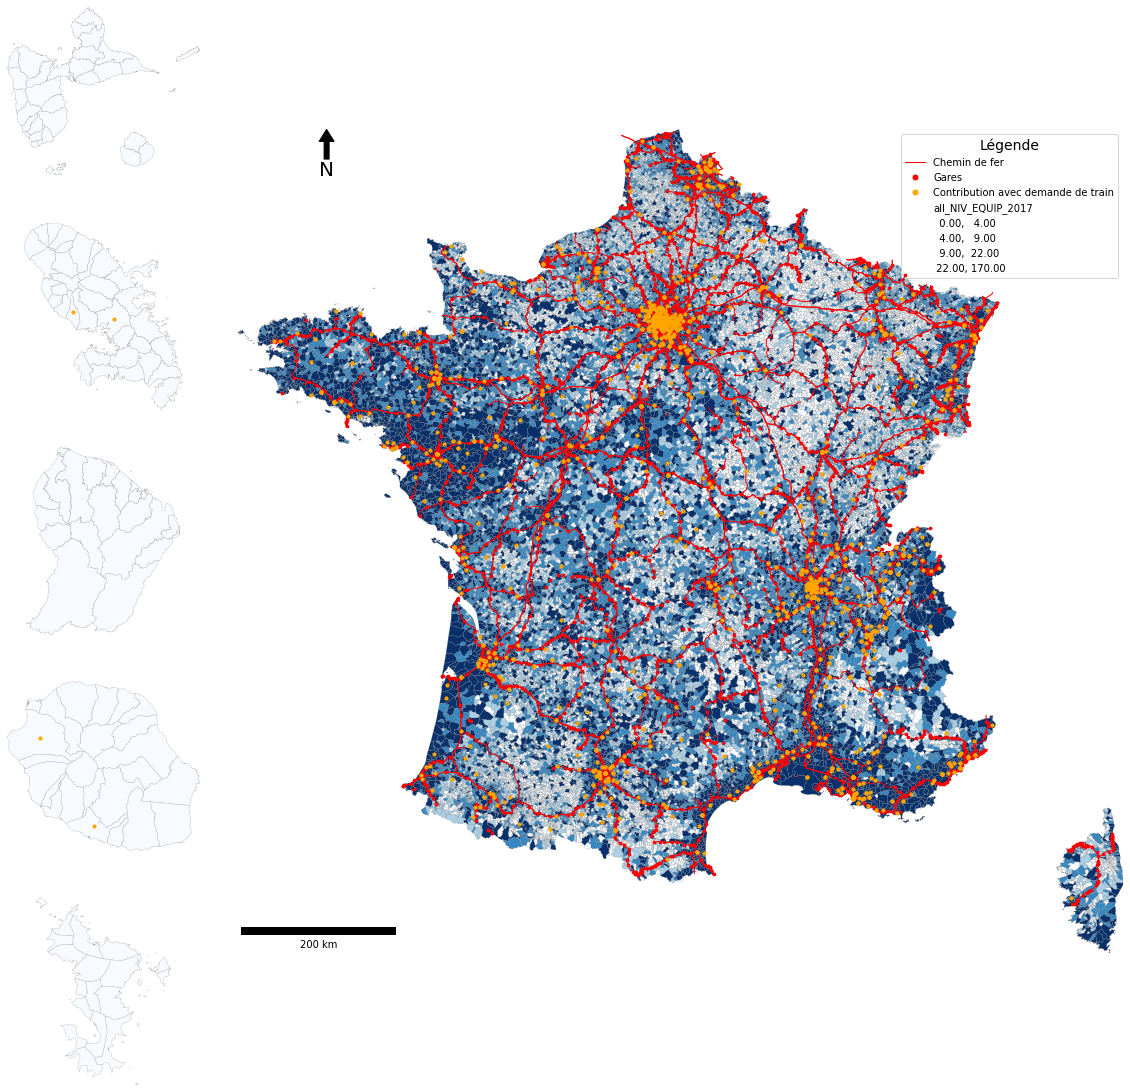

In [ ]:
# On initialise la figure par une choropleth
fp.init_plot(choropleth_column,scheme='QUANTILES', k=4,legend=True,cmap="Blues",edgecolor="gray",linewidth=0.2)

# On affiche les données que l'on souhaite
train_rail_gdf.plot(ax = fp.axes["MET"],color="red",linewidth=1,zorder=98) # chemin de fer
train_station_gdf.plot(ax = fp.axes["MET"],color="red",markersize=7,zorder=99) # station de train
# "dep_code" permet de répartir la trace dans les différents sous-plot de la figure
fp.add_trace_wo_column(motifs_train,"dep_code",markersize=10,color="orange",zorder=100) # motif 

# Ajout de l'échelle
fp.axes["MET"].add_artist(ScaleBar(1,location="lower left"))

# Ajout de la fléche Nord
x, y, arrow_length = 0.1, 1., 0.05
fp.axes["MET"].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=fp.axes["MET"].transAxes)
clear_output(wait=True)

# LEGEND
legend_elements = [Line2D([0], [0], color='r', lw=1, label="Chemin de fer"),
                Line2D([0], [0], marker='o', color='w', label='Gares', markerfacecolor='red', markersize=7),
                Line2D([0], [0], marker='o', color='w', label='Contribution avec demande de train',markerfacecolor='orange', markersize=7)]
                
# Récupére la légende générée par Geopandas 
previous_legend = fp.axes["MET"].get_legend().get_lines()

for ix,pl in enumerate(previous_legend):
    label = fp.axes["MET"].get_legend().get_texts()[ix].get_text()
    pl.set_label(label)

#Puis, on l'inclue avec notre légende custom
legend_elements.extend([Line2D([0], [0], color='w', lw=1, label=f"{choropleth_column}")]+previous_legend) #get_texts()[0].get_text()

# On redessine la légende
legend = fp.axes["MET"].legend(handles=legend_elements, loc='upper right',title="Légende",fontsize="10") # changer fontsize pour la taille de la police
legend.get_title().set_fontsize('14')


In [ ]:
fp.fig.savefig("train.png") # On peut sauvegarde la figure (changer l'extension pour changer le format du ficher de sortie)

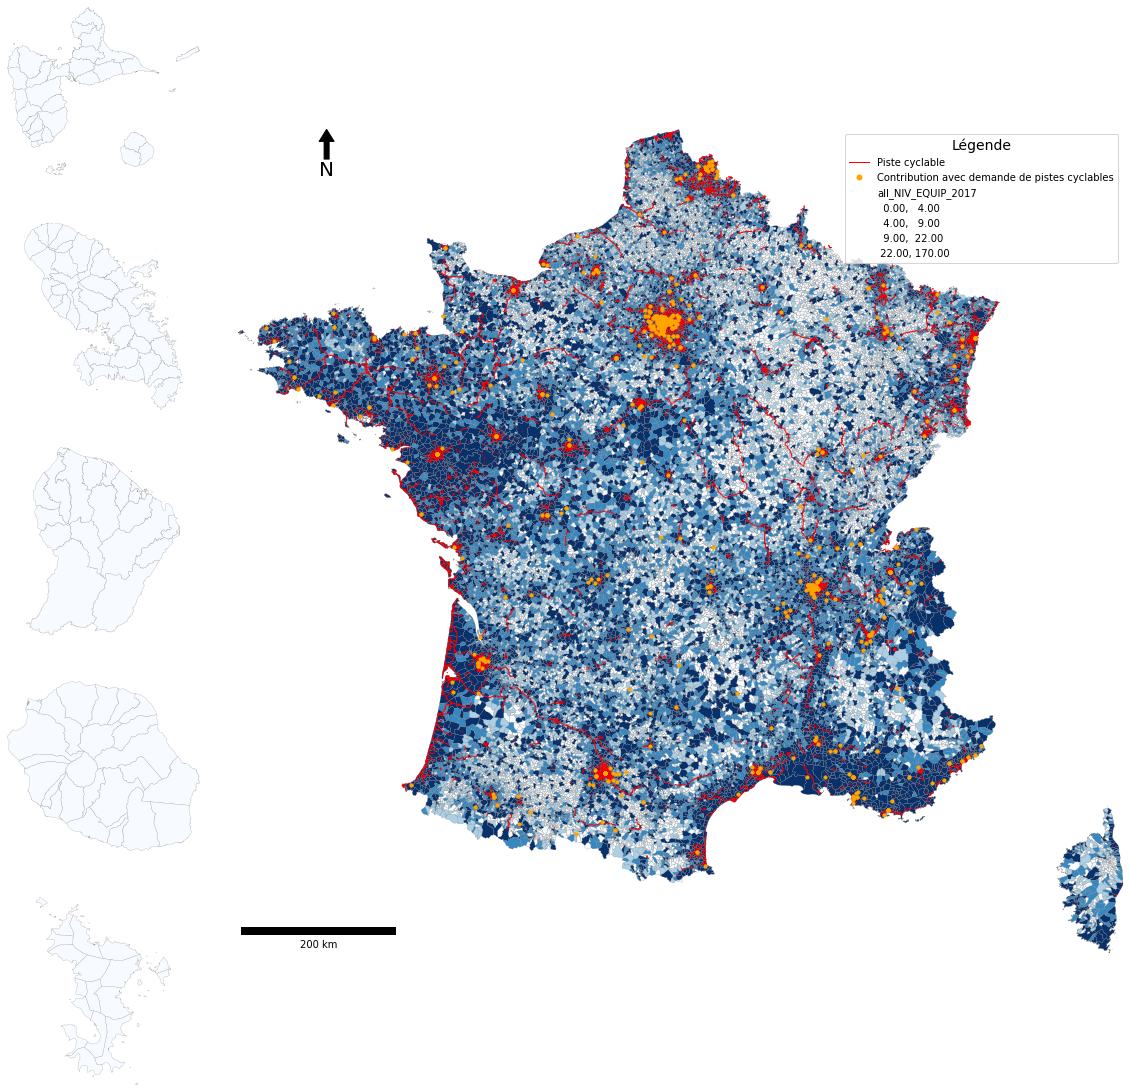

In [ ]:
fp.init_plot(choropleth_column,scheme='QUANTILES', k=4,legend=True,cmap="Blues",edgecolor="gray",linewidth=0.2)
clear_output(wait=True)

bikeways_gdf.plot(ax = fp.axes["MET"],color="red",linewidth=1)
fp.add_trace_wo_column(motifs_vélo,"dep_code",markersize=10,color="orange",zorder=100)


fp.axes["MET"].add_artist(ScaleBar(1,location="lower left"))

x, y, arrow_length = 0.1, 1., 0.05
fp.axes["MET"].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=fp.axes["MET"].transAxes)

legend_elements = [Line2D([0], [0], color='r', lw=1, label="Piste cyclable"),
                Line2D([0], [0], marker='o', color='w', label='Contribution avec demande de pistes cyclables',markerfacecolor='orange', markersize=7),
                ]

previous_legend = fp.axes["MET"].get_legend().get_lines()

for ix,pl in enumerate(previous_legend):
    label = fp.axes["MET"].get_legend().get_texts()[ix].get_text()
    pl.set_label(label)
legend_elements.extend([Line2D([0], [0], color='w', lw=1, label=f"{choropleth_column}")]+previous_legend) #get_texts()[0].get_text()

legend = fp.axes["MET"].legend(handles=legend_elements, loc='best',title="Légende",fontsize="10") # changer fontsize pour la taille de la police
legend.get_title().set_fontsize('14')

clear_output(wait=True)


In [ ]:
fp.fig.savefig("piste_cyclable.png") # On peut sauvegarde la figure (changer l'extension pour changer le format du ficher de sortie)